# Decision Tree: make_moons

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Reference: https://www.kaggle.com/code/fareselmenshawii/decision-tree-from-scratch

## Generate the Two Moons Data Set

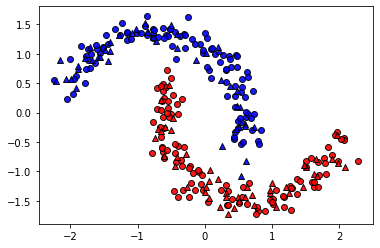

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=300, noise=0.1, random_state=0)

# Rotate the X data by "th" radians
th = np.deg2rad(20)
X = X @ np.array([[np.cos(th), -np.sin(th)],[np.sin(th), np.cos(th)]])

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

def plot2Ddata(X_train,X_test,y_train,y_test):
    plt.scatter(X_train[y_train == 0,0],X_train[y_train == 0,1],
                color='b',marker='o',alpha=0.9,edgecolors='k')
    plt.scatter(X_train[y_train == 1,0],X_train[y_train == 1,1],
                color='r',marker='o',alpha=0.9,edgecolors='k')
    plt.scatter(X_test[y_test == 0,0],X_test[y_test == 0,1],
                color='b',marker='^',alpha=0.9,edgecolors='k')
    plt.scatter(X_test[y_test == 1,0],X_test[y_test == 1,1],
                color='r',marker='^',alpha=0.9,edgecolors='k')
    
plot2Ddata(X_train,X_test,y_train,y_test)

## Create Node class and Decision Tree class

In [3]:
class Node:
    def __init__(self, split_data=None, left=None, right=None, value_if_leaf=None):
        self.split_data = split_data                  # contains gini, feat, thresh, left_data, right_data 
        self.left = left                              # contains the left child Node
        self.right = right                            # contains the right child Node
        self.value_if_leaf = value_if_leaf            # None if not leaf, predicted value if leaf.

class DecisionTree:
    def __init__(self, min_samples_split=2, min_samples_leaf=1, max_depth=10):
        self.min_samples_split = min_samples_split    # Min no. of samples to split the nodes
        self.min_samples_leaf = min_samples_leaf      # Min no. of samples required to be a leaf
        self.max_depth = max_depth                    # Max depth of the decision tree
        self.actual_depth = 0                         # Depth of tree after fitting
    
    def find_split(self, data):             # data contains (X, y)
        N = data.shape[0]
        
        # Dictionary of best_split attributes
        best_split = {'gini': 1, 'feat': None, 'thresh': None}
        
        for feat in range(data.shape[1]-1):
            
            sorted_data = data[data[:, feat].argsort(),:]
            p = np.sum(data[:,-1]) / N
            orig_gini = 2 * p * (1 - p)
            
            for i in range(N-1):
                
                left = sorted_data[:(i+1),:]
                right = sorted_data[(i+1):,:]

                p1 = np.sum(left[:,-1]) / (i+1)
                p2 = np.sum(right[:,-1]) / (N - (i+1))
                gini_left = 2 * p1 * (1 - p1)
                gini_right = 2 * p2 * (1 - p2)
                gini = ((i+1) * gini_left + (N - (i+1)) * gini_right) / N

                if gini < best_split["gini"]:
                    best_split["gini"] = gini
                    best_split["feat"] = feat
                    best_split["thresh"] = (left[-1,feat] + right[0,feat]) / 2
                    best_split["left_data"] = left
                    best_split["right_data"] = right
                    best_split["gini_dec"] = (orig_gini - gini) * N
        
        return best_split
    
    def fit(self, X, y):
        data = np.hstack((X, y.reshape(-1,1)))
        self.feat_imp = np.zeros(X.shape[1])
        
        # For visualization of boundaries
        print("Order of Node creation:")
        plt.figure(figsize=(15,10))
        plt.scatter(X[y == 0,0], X[y == 0,1], c='b')
        plt.scatter(X[y == 1,0], X[y == 1,1], c='r')
        self.root = self.build_tree(data)
        self.feat_imp = self.feat_imp / np.sum(self.feat_imp)
        plt.show()
        
    def build_tree(self, data, curr_depth=0):
        
        N = data.shape[0]
        self.actual_depth = np.max(np.array([curr_depth, self.actual_depth]))
        
        if N >= self.min_samples_split and curr_depth < self.max_depth and\
            len(np.unique(data[:,-1])) > 1:
            
            best_split = self.find_split(data)
            N_left = best_split["left_data"].shape[0]
            N_right = best_split["right_data"].shape[0]

            # Attempt to create left and right children Nodes
            if N_left >= self.min_samples_leaf and \
                N_right >= self.min_samples_leaf:
                
                gini, thresh, feat, gini_dec = best_split["gini"], best_split["thresh"], \
                                               best_split["feat"], best_split["gini_dec"]
                
                self.feat_imp[feat] += best_split["gini_dec"]
                
                # Visualize the decision boundary at this Node
                if best_split["feat"] == 0:
                    xp = best_split["thresh"] * np.array([1, 1])
                    yp = np.array([np.min(data[:,1]), np.max(data[:,1])])
                    plt.plot(xp, yp, 'k')
                    plt.text(xp[0] + 0.05, np.mean(yp), s=f"{gini:.3f}, {curr_depth}, {feat}", 
                             rotation="vertical", va="center")
                else:
                    xp = np.array([np.min(data[:,0]), np.max(data[:,0])])
                    yp = best_split["thresh"] * np.array([1, 1])
                    plt.plot(xp, yp, 'k')
                    plt.text(np.mean(xp), yp[0] + 0.05, 
                             s=f"{gini:.3f}, {curr_depth}, {feat}", 
                             ha="center")
                
                print(f"  depth={curr_depth}, thresh={thresh:7.3f}, feat={feat}," + 
                      f" gini={gini:.3f}, gini_dec={gini_dec:.3f}")
                
                # Recursive call to build_tree
                left_node = self.build_tree(best_split["left_data"], curr_depth+1)
                right_node = self.build_tree(best_split["right_data"], curr_depth+1)
            
                return Node(split_data=best_split, left=left_node, right=right_node)
            
            # If attempt failed, then don't split and return this Node as a leaf
            else:
                leaf_value = 2 * np.sum(data[:,-1]) > N
                return Node(value_if_leaf=leaf_value)
            
        leaf_value = 2 * np.sum(data[:,-1]) > N
        return Node(value_if_leaf=leaf_value)
    
    def predict(self, X):
        y_pred = np.zeros(len(X))
        for i in range(len(X)):
            nd = self.root
            while nd.value_if_leaf == None:
                if X[i,nd.split_data["feat"]] < nd.split_data["thresh"]:
                    nd = nd.left
                else:
                    nd = nd.right
            y_pred[i] = nd.value_if_leaf
        return y_pred
    
    def plot_decision(self, X, y):
        nx, ny = 100, 100
        xv, yv = np.meshgrid(np.linspace(-3,3,nx), 
                             np.linspace(-3,3,ny))
        xy = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
        zv = self.predict(xy)
        plt.figure(figsize=(15,10))
        plt.scatter(xy[zv == 0,0], xy[zv == 0,1], c='b', s=10, alpha=0.2)
        plt.scatter(xy[zv == 1,0], xy[zv == 1,1], c='r', s=10, alpha=0.2)
        plt.scatter(X[y == 0,0],X[y == 0,1], color='b', marker='o',
                    alpha=0.9, edgecolors='k', label='(-) Training samples')
        plt.scatter(X[y == 1,0],X[y == 1,1], color='r', marker='o',
                    alpha=0.9, edgecolors='k', label='(+) Training samples')
        plt.legend()
        plt.show()

## Train the decision tree on the training set

Order of Node creation:
  depth=0, thresh=  0.257, feat=1, gini=0.227, gini_dec=57.249
  depth=1, thresh= -0.550, feat=1, gini=0.184, gini_dec=11.708
  depth=2, thresh=  0.052, feat=0, gini=0.228, gini_dec=11.584
  depth=3, thresh= -1.410, feat=0, gini=0.000, gini_dec=1.895
  depth=3, thresh=  1.391, feat=0, gini=0.000, gini_dec=7.917
  depth=1, thresh=  0.501, feat=1, gini=0.114, gini_dec=3.881
  depth=2, thresh= -0.069, feat=0, gini=0.122, gini_dec=5.143
  depth=3, thresh= -1.343, feat=0, gini=0.000, gini_dec=1.714
  depth=2, thresh=  0.731, feat=1, gini=0.042, gini_dec=0.567
  depth=3, thresh=  0.723, feat=1, gini=0.152, gini_dec=1.515
  depth=4, thresh= -0.198, feat=0, gini=0.145, gini_dec=0.218


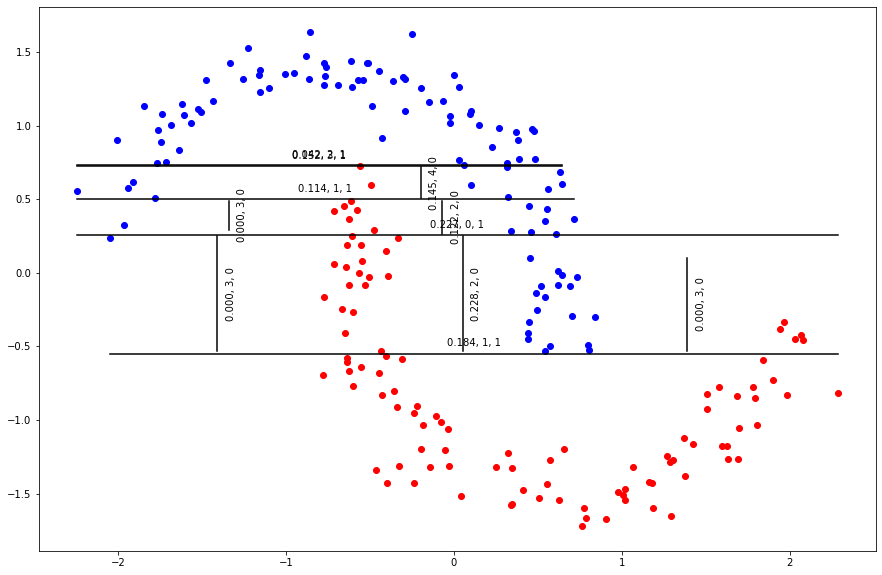

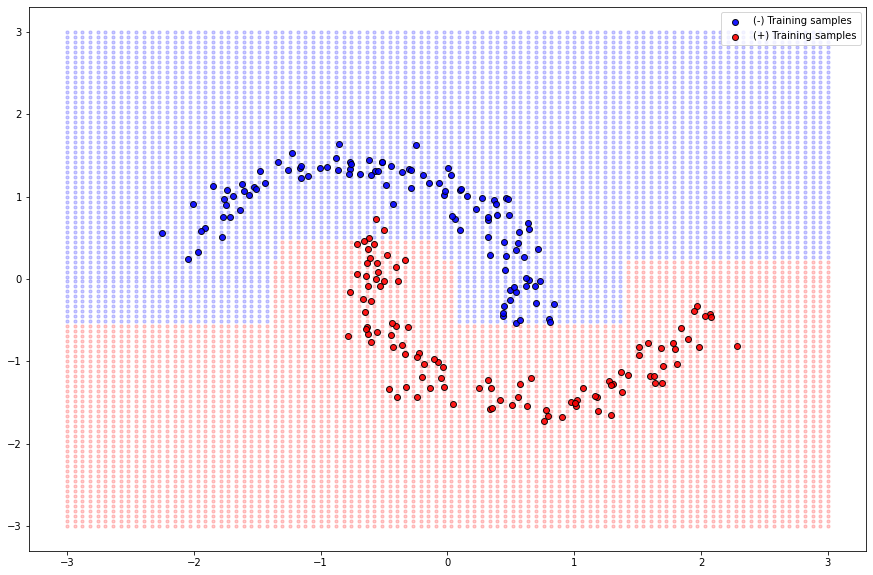

In [4]:
mdl = DecisionTree(min_samples_split=3, max_depth=5)
mdl.fit(X_train, y_train)
mdl.plot_decision(X_train, y_train)

## Visualize the Decision Tree

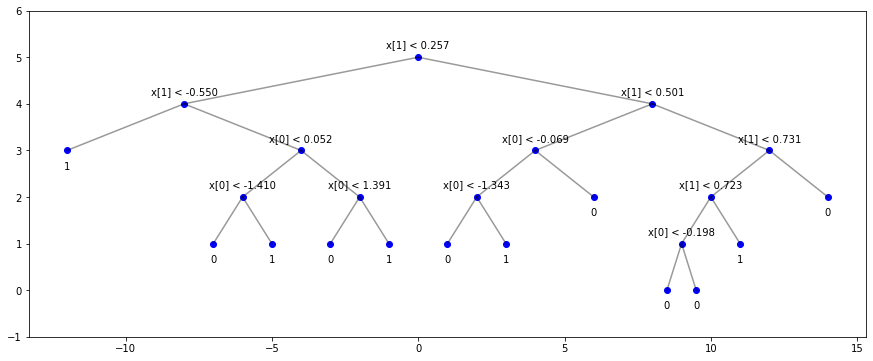

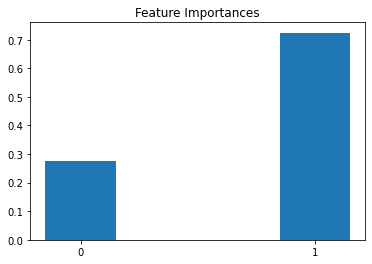

In [5]:
root = mdl.root
stack_nd, stack_x, stack_y = [], [], []
stack_nd.append(root)
stack_x.append(0)
stack_y.append(mdl.actual_depth)
x_range = 2 ** (mdl.actual_depth - 2)

plt.figure(figsize=(15,6))

while stack_nd:
    
    # Pop the stack
    nd, x, y = stack_nd.pop(), stack_x.pop(), stack_y.pop() 
    
    # Check if leaf node or not
    if nd.value_if_leaf == None:
        feat = nd.split_data["feat"]
        thresh = nd.split_data["thresh"]
        plt.scatter(x, y, c='b')
        plt.text(x, y + 0.2, s=f"x[{feat}] < {thresh:.3f}", 
                 ha="center", fontsize=10)
        
        next_xr = x + x_range / 2 ** (mdl.actual_depth - y)
        next_xl = x - x_range / 2 ** (mdl.actual_depth - y)
        
        plt.plot(np.array([x, next_xr]), np.array([y, y-1]), 'k', alpha=0.4)
        plt.plot(np.array([x, next_xl]), np.array([y, y-1]), 'k', alpha=0.4)
        
        # Push the right child, then left child
        stack_nd.append(nd.right), stack_nd.append(nd.left)
        stack_x.append(next_xr),   stack_x.append(next_xl)
        stack_y.append(y-1),       stack_y.append(y-1)
    else:
        plt.scatter(x, y, c='b')
        plt.text(x, y - 0.4, s=f"{int(nd.value_if_leaf)}", ha="center")

plt.ylim([-1, mdl.actual_depth+1])
plt.show()

# Visualize feature importance bar plot
plt.bar(np.array([0, 1]),mdl.feat_imp, width=0.3)
plt.xticks(np.array([0, 1]))
plt.title('Feature Importances')
plt.show()

## Comparison with the Built-in Decision Tree in sklearn

<Figure size 720x576 with 0 Axes>

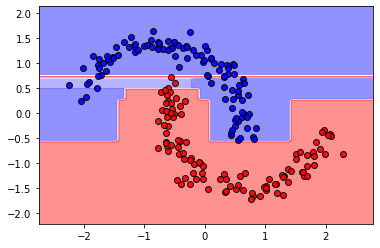

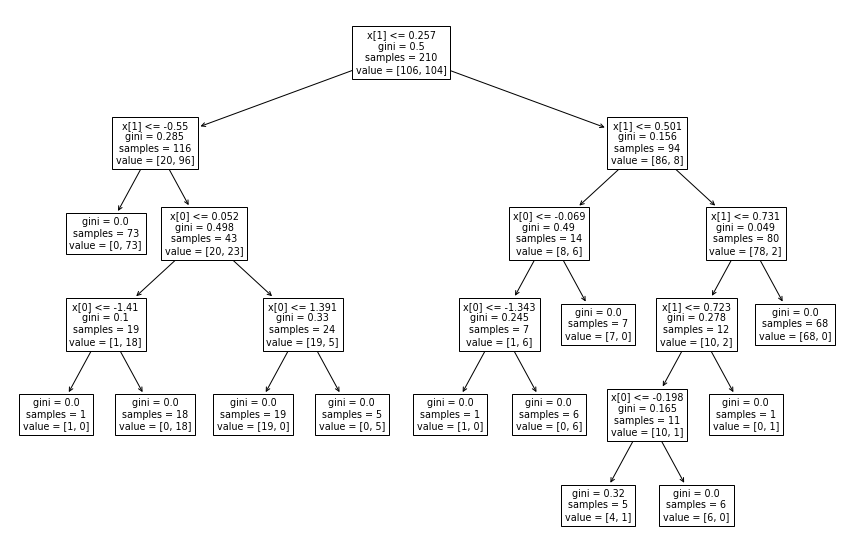

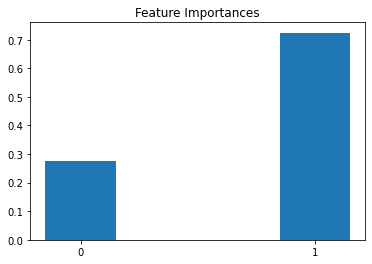

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import DecisionBoundaryDisplay

tree = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
tree.fit(X_train, y_train)

# Plot decision boundary
plt.figure(figsize=(10,8))
plt.set_cmap('bwr')
DecisionBoundaryDisplay.from_estimator(tree, X_train, alpha=0.5, eps=0.5)
plt.scatter(X_train[y_train == 0,0],X_train[y_train == 0,1], color='b', marker='o',
            alpha=0.9, edgecolors='k', label='(-) Training samples')
plt.scatter(X_train[y_train == 1,0],X_train[y_train == 1,1], color='r', marker='o',
            alpha=0.9, edgecolors='k', label='(+) Training samples')
plt.show()

# Plot decision tree
plt.figure(figsize=(15,10))
plot_tree(tree)
plt.show()

# Plot mean-decrease-in-gini-impurity feature importance
plt.bar(np.array([0, 1]),tree.feature_importances_, width=0.3)
plt.xticks(np.array([0, 1]))
plt.title('Feature Importances')
plt.show()